(Visit the
[documentation](https://datafold-dev.gitlab.io/datafold/tutorial_index.html) page
to view the executed notebook.)

# Extended Dynamic Mode Decomposition on Limit Cycle

In this tutorial, we explore the (Extended-) Dynamic Mode Decomposition (E-DMD). We set up a non-linear ordinary differential equation (ODE) system, generate time series data with it and model the dynamics with an `EDMD` model. 

Note that all models for time series modelling require a `TSCDataFrame` type to fit a model. The initial conditions for the `predict` method can be either a `numpy.ndarray`, a `pandas.DataFrame`, or in some circumstances (when multiple samples are required to define an initial condition) a `TSCDataFrame`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

from datafold.appfold import EDMD
from datafold.dynfold import DMDFull
from datafold.dynfold.transform import TSCPolynomialFeatures, TSCRadialBasis
from datafold.pcfold import GaussianKernel, TSCDataFrame

## Set up ODE system

We set up a Hopf ODE system:

$$
\dot{y}_0 = -y_1 + y_0 (\mu - y_0^2 - y_1^2) \\
\dot{y}_1 = y_0 + y_1 (\mu - y_0^2 - y_1^2)
$$

with $\mu=1$. The ODE system has an circle shaped attractor which is centered at the origin. All sampled initial conditions are off the attractor (i.e. the time series are sampled on the transient phase space region). 

We solve the system by integration with a Runge-Kutta45 scheme using scipy's ODE solver. The return type of this function is a `TSCDataFrame` and includes the time series for each initial condition (a row in argument `initial_conditions`).

In [2]:
def solve_limit_cycle(initial_conditions, t_eval):
    def limit_cycle(t, y):
        """ODE system."""
        mu = 1
        y_dot = np.zeros(2)

        factor = mu - y[0] ** 2 - y[1] ** 2

        y_dot[0] = -y[1] + y[0] * factor
        y_dot[1] = y[0] + y[1] * factor
        return y_dot
    def linear_system(t, y):
        """ODE system."""
        mu = 1
        y_dot = np.zeros(2)

        factor = mu

        y_dot[0] = -y[1]# + y[0] * factor
        y_dot[1] = y[0]# + y[1] * factor
        return y_dot

    assert initial_conditions.ndim == 2
    assert initial_conditions.shape[1] == 2

    time_series_dfs = []

    for ic in initial_conditions:
        solution = solve_ivp(
            linear_system, t_span=(t_eval[0], t_eval[-1]), y0=ic, t_eval=t_eval
        )

        solution = pd.DataFrame(
            data=solution["y"].T,
            index=solution["t"],
            columns=["x1", "x2"],
        )

        time_series_dfs.append(solution)

    return TSCDataFrame.from_frame_list(time_series_dfs)

## Sampling the dynamical system

We now start collecting time series data from the Hopf system (our training set). To sample the phase space, we systematically distribute initial conditions and solve the ODE system for rather short time intervals.

In [3]:
nr_time_steps = 30
t_eval = np.linspace(0, 2, 21)

initial_conditions = np.array(
    np.meshgrid(np.linspace(-2, 2, 10), np.linspace(-2, 2, 10))
).T.reshape(-1, 2)

tsc_data = solve_limit_cycle(initial_conditions, t_eval)

print(f"time delta: {tsc_data.delta_time}")
print(f"#time series: {tsc_data.n_timeseries}")
print(f"#time steps per time series: {tsc_data.n_timesteps}")
print(f"(n_samples, n_features): {tsc_data.shape}")
print(f"time interval {tsc_data.time_interval()}")
print(f"Same time values: {tsc_data.is_same_time_values()}")
print("")
print("Data snippet:")
tsc_data

time delta: 0.09999999999999999
#time series: 100
#time steps per time series: 21
(n_samples, n_features): (2100, 2)
time interval (0.0, 2.0)
Same time values: True

Data snippet:


feature        x1        x2
ID time                    
0  0.0  -2.000000 -2.000000
   0.1  -1.790341 -2.189675
   0.2  -1.562777 -2.357631
   0.3  -1.319615 -2.502191
   0.4  -1.063308 -2.621736
...           ...       ...
99 1.6  -2.058699  1.940777
   1.7  -2.241986  1.725371
   1.8  -2.402860  1.492586
   1.9  -2.539753  1.244864
   2.0  -2.651309  0.984895

[2100 rows x 2 columns]

### Plot: Sampled time series used for training

In [4]:
# function to add a single arrow in the following time series plots
idx_arrow = np.array([t_eval.shape[0] // 2 - 1, t_eval.shape[0] // 2])


def include_arrow(ax, df):
    arrow = df.iloc[idx_arrow, :]
    ax.arrow(
        arrow.iloc[0, 0],
        arrow.iloc[0, 1],
        dx=arrow.iloc[1, 0] - arrow.iloc[0, 0],
        dy=arrow.iloc[1, 1] - arrow.iloc[0, 1],
        color="black",
        head_width=0.05,
    )

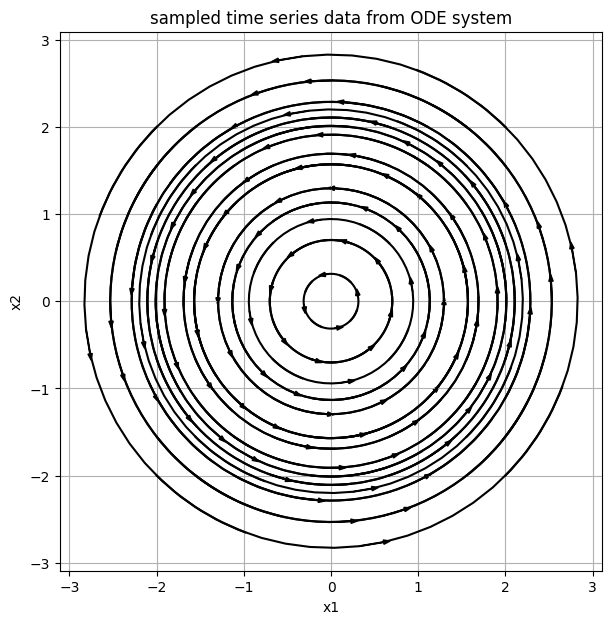

In [5]:
fig, ax = plt.subplots(figsize=[7, 7])

for _id, df in tsc_data.itertimeseries():
    ax.plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax, df)

ax.set_title("sampled time series data from ODE system")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.axis("equal")
ax.grid();

## 1. DMD: Identity dictionary

In our first model, we use a Dynamic Mode Decomposition (in `datafold.dynfold.dmd`) model and decompose the data in spatio-temporal coordinates using the original form of the time series. In other words, our dictionary only includes the state identities "x1" and "x2" as observable functions. 

In the first attempt, we use the `DMDFull` model directly. The same could be accomplished with `EDMD(dict_step=["id", TSCIdentity()]`).

Note that the DMD-based models' API aligns with scikit-learn. However, the input type of `X` is restricted to a `TSCDataFrame`. The `predict` method allows setting an array of `time_values`, where we can choose at which time samples to evaluate the model. In our case, we are interested in reconstructing the training data, we leave the parameter `time_values=None`. The model then uses the same time values that were available during `fit`.

In [6]:
dmd = DMDFull().fit(X=tsc_data, store_system_matrix=True)  # must be TSCDataFrame
dmd_values = dmd.predict(tsc_data.initial_states(), time_values=None)

# Will be a red line in the plot
dmd_values_oos = dmd.predict(np.array([-1.8, 2]), time_values=np.linspace(0, 100, 1000))

print("Data snipped with predicted time series data")
dmd_values

Data snipped with predicted time series data


feature        x1        x2
ID time                    
0  0.0  -2.000000 -2.000000
   0.1  -1.790292 -2.189709
   0.2  -1.562689 -2.357530
   0.3  -1.319466 -2.501784
   0.4  -1.063055 -2.621030
...           ...       ...
99 1.6  -2.058145  1.939992
   1.7  -2.241572  1.724778
   1.8  -2.402591  1.492324
   1.9  -2.539594  1.244953
   2.0  -2.651210  0.985139

[2100 rows x 2 columns]

### Compare with training data 

We can now compare the original time series data with the data-driven reconstruction of the DMD model. From what we see in the plots below is that the DMD model performs poorly. This is not surprising at this stage, because we learn the Koopman matrix directly on the available states. The computed Koopman matrix is therefore a $K \in \mathbb{R}^{[2 \times 2]}$ describing a linear system

$$ x_{n+1} = K x_n $$

and not being able to desribe a complex dynamics such as this of the underlying system. Note that the learnt system equation implies that we have modelled a dicrete system, while the underling system is continuous. This is a result from the discretely sampled data with a fixed time interval. Because we are in this easier setting of a 2-by-2 matrix, in the next cell, we look at the relation to a continuous system.

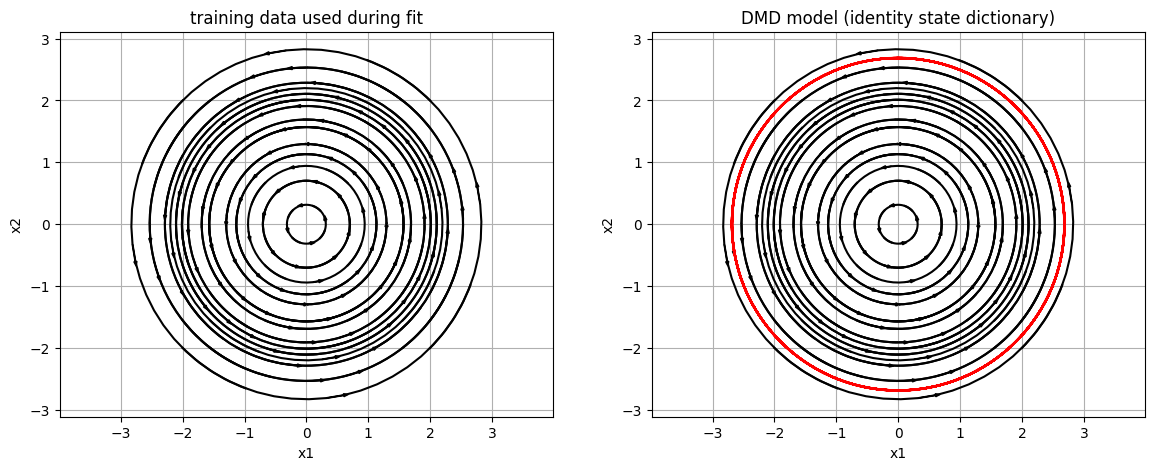

In [7]:
f, ax = plt.subplots(1, 2, figsize=(14, 5))
for _id, df in tsc_data.itertimeseries():
    ax[0].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax[0], df)

ax[0].set_title("training data used during fit")
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
ax[0].axis("equal")
ax[0].grid()

for _id, df in dmd_values.itertimeseries():
    ax[1].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax[1], df)

ax[1].set_title("DMD model (identity state dictionary)")
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
ax[1].axis("equal")
ax[1].grid()


# generate red "out-of-sample" prediction, for extra analysis below
ax[1].plot(dmd_values_oos["x1"], dmd_values_oos["x2"], 0.1, c="red")
include_arrow(ax[1], dmd_values_oos)

### Connection of discrete and continuous linear dynamical system

We start with the form of a continuous linear dynamical system

$$ \frac{dx}{dt} = A x $$

where $A$ is a constant system matrix. To connect this representation to our learnt discrete system ($x_{n+1} = K x_n$), we first discretize the time derivative on the left hand side with a usual forward finite difference

$$\frac{x_{n+1} - x_{n}}{\tau} = A x_n$$

where we set $\tau$ to the time sampling interval of the available time series data (in the data from the Hopf system $\tau = 0.02$). This is again a discrete system; then by rearranging the equation to the future state $x_{n+1}$ reveals

$$x_{n+1} = \underbrace{(I + \tau \cdot A)}_K x_n$$

We can then analyze both system matrices -- either in terms of a discrete system $K$ or via the continuous system matrix $A$.

$$A = \frac{K - I}{\tau}$$

Because we are still in the case of $A \in \mathbb{R}^{[2 \times 2]}$, where the observable states to approximate $K$ directly match the original states, we can now look at the the phase portrait and apply [stability theory](https://en.wikipedia.org/wiki/Stability_theory). With the computed values below, $\operatorname{trace}(A)$ and $\operatorname{det}{A}$, we can classify our current system as a "spiral sink" -- the determinant is larger than $\Delta$ and the trace is negative; see Poincaré diagram in the stability theory article. This matches the fast decaying red trajectory in the plot above.

Because the underlying Hopf system, that we aim to model, has quite different dynamics than a spiral sink, we continue our tutorial to improve the quality of our model.

In [8]:
generator_A = (dmd.koopman_matrix_ - np.eye(2)) / dmd.dt_

det = np.linalg.det(generator_A)
trace = np.trace(generator_A)

print("Relevant values for the stability analysis: \n")
print(f"determinant of A: {det}")
print(f"trace of A: {trace}")

print(f"Delta {1/4. * trace ** 2} ")

Relevant values for the stability analysis: 

determinant of A: 0.9995891899946422
trace of A: -0.09999550075791343
Delta 0.002499775042956466 


## 2. EDMD: Polynomial feature dictionary

We now get to the "extended" part of a Dynamic Model Decomposition: We define a *dictionary* in which we process the time series data before we fit a DMD model with it. For this, we use the `datafold.appfold.EDMD` class, which is a [`sklearn.pipeline.Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html?highlight=pipeline#sklearn.pipeline.Pipeline). In the `EDMD` model, a dictionary can be a flexible number of transform models that are process the time series data consecutively (in the same order as defined). The final estimator has to be a `datafold.dynfold.dmd.DMDBase` model and defaults to `DMDFull`.  

Choosing the "right" dictionary is not an easy task and is similar to "model selection" in classical machine learning. In our choice of dictionary, we can include expert knowledge, e.g. if we know the principle equations from an underlying physical system from which time series are collected. We can also apply methods from functional theory to represent the data in another basis to linearize the unknown dynamics manifold. 

In the first dictionary, we use `TSCPolynomialFeatures` which is a wrapper of [`sklearn.preprocessing.PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html?highlight=polynomial#sklearn.preprocessing.PolynomialFeatures) to support `TSCDataFrame` type.

In [9]:
dict_step = [
    (
        "polynomial",
        TSCPolynomialFeatures(degree=3),
    )
]

edmd_poly = EDMD(dict_steps=dict_step, include_id_state=True).fit(X=tsc_data)
edmd_poly_values = edmd_poly.predict(tsc_data.initial_states())

### Analyze the dictionary

Before we compare the model's time series data to the training data, we investigate how we to analyze the actual process of dictionary transformations in an `EDMD` model.  

This is useful if we are interested and want to investigate the values of the "dictionary space", i.e. the data representation after the transformations were applied to the original data and before it is passed to the final DMD model. To accomblish this we can use the `transform` method of `EDMD`, which only applies the dictionary transformations without processing it through the final estimator. 

In the following cell, we see that the result is a `TSCDataFrame`, which includes the original states "x1" and "x2" plus the generated polynomial features. 

The single dictionary models are accessible with the specified name via `named_steps`. Here, we access the model and its attribute `TSCPolynomialFeatures.powers_` through the `EDMD` model.

In [10]:
# access models in the dictionary, the name was given in "dict_step" above
print(edmd_poly.named_steps["polynomial"])

print("")
print("polynomial degrees for data (first column 'x1' and second 'x2'):")
print(edmd_poly.named_steps["polynomial"].powers_)

print("")
print("Dictionary space values:")
edmd_poly.transform(tsc_data)

TSCPolynomialFeatures(degree=3)

polynomial degrees for data (first column 'x1' and second 'x2'):
[[2 0]
 [1 1]
 [0 2]
 [3 0]
 [2 1]
 [1 2]
 [0 3]]

Dictionary space values:


feature        x1        x2      x1^2     x1 x2      x2^2       x1^3  \
ID time                                                                
0  0.0  -2.000000 -2.000000  4.000000  4.000000  4.000000  -8.000000   
   0.1  -1.790341 -2.189675  3.205323  3.920266  4.794677  -5.738622   
   0.2  -1.562777 -2.357631  2.442272  3.684452  5.558424  -3.816727   
   0.3  -1.319615 -2.502191  1.741383  3.301928  6.260961  -2.297954   
   0.4  -1.063308 -2.621736  1.130623  2.787713  6.873502  -1.202201   
...           ...       ...       ...       ...       ...        ...   
99 1.6  -2.058699  1.940777  4.238240 -3.995474  3.766614  -8.725259   
   1.7  -2.241986  1.725371  5.026499 -3.868257  2.976905 -11.269339   
   1.8  -2.402860  1.492586  5.773736 -3.586476  2.227814 -13.873480   
   1.9  -2.539753  1.244864  6.450346 -3.161646  1.549685 -16.382285   
   2.0  -2.651309  0.984895  7.029441 -2.611261  0.970018 -18.637223   

feature   x1^2 x2   x1 x2^2       x2^3  
ID time                                 
0  0.0  -8.000000 -8.000000  -8.000000  
   0.1  -7.018615 -8.584110 -10.498786  
   0.2  -5.757977 -8.686579 -13.104714  
   0.3  -4.357273 -8.262056 -15.666121  
   0.4  -2.964197 -7.308648 -18.020511  
...           ...       ...        ...  
99 1.6   8.225477 -7.754322   7.310155  
   1.7   8.672576 -6.674178   5.136266  
   1.8   8.617801 -5.353126   3.325206  
   1.9   8.029800 -3.935818   1.929147  
   2.0   6.923260 -2.571817   0.955366  

[2100 rows x 9 columns]

### Compare with training data

We see that reconstruction of time series improved and the phase portrait now looks a lot better than the previous DMD approach. However, there are still obvious differences and some time series even cross, which is not a behaviour of the original system.

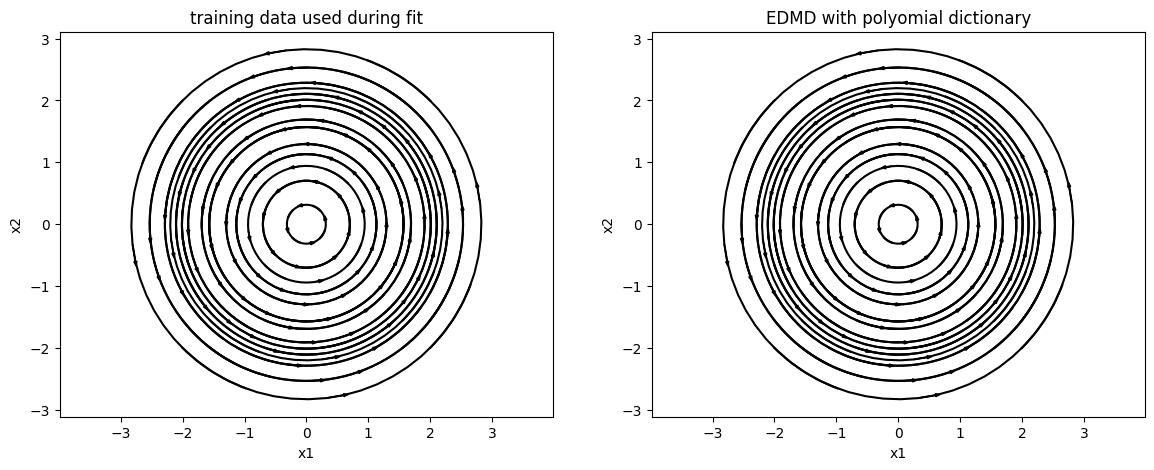

In [11]:
f, ax = plt.subplots(1, 2, figsize=(14, 5))
for _id, df in tsc_data.itertimeseries():
    ax[0].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax[0], df)

ax[0].set_title("training data used during fit")
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
ax[0].axis("equal")

for _id, df in edmd_poly_values.itertimeseries():
    ax[1].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax[1], df)

ax[1].set_title("EDMD with polyomial dictionary")
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
ax[1].axis("equal");

## 3. EDMD: Radial basis function dictionary

In our last attempt, we set up a dictionary with `TSCRadialBasis`. The transform class computes coefficients of each time series sample to a set of radial basis functions, which centres' are distributed on the phase space. The radial basis functions, therefore, provide a way to linearize the phase space's manifold. Here we choose a Gaussian kernel and set the centre of the functions to the initial condition states.

In the time series in "dictionary space," we see that the feature dimension is now much greater than at the beginning (i.e. we provide a larger set of observables to compute the Koopman operator).

In [12]:
dict_step = [
    (
        "rbf",
        TSCRadialBasis(
            kernel=GaussianKernel(epsilon=0.17), center_type="initial_condition"
        ),
    )
]

edmd_rbf = EDMD(dict_steps=dict_step, include_id_state=True).fit(
    X=tsc_data
)  # Note that the "extended" part is in the transformations
edmd_rbf_values = edmd_rbf.predict(tsc_data.initial_states())

len_koopman_matrix = len(edmd_rbf.named_steps["dmd"].eigenvectors_right_)
print(f"shape of Koopman matrix: {len_koopman_matrix} x {len_koopman_matrix}")
edmd_rbf.transform(tsc_data)

shape of Koopman matrix: 102 x 102


feature        x1        x2          rbf0          rbf1          rbf2  \
ID time                                                                 
0  0.0  -2.000000 -2.000000  1.000000e+00  5.593538e-01  9.789180e-02   
   0.1  -1.790341 -2.189675  7.904933e-01  2.692933e-01  2.870293e-02   
   0.2  -1.562777 -2.357631  3.912443e-01  8.591649e-02  5.903074e-03   
   0.3  -1.319615 -2.502191  1.220536e-01  1.836725e-02  8.647900e-04   
   0.4  -1.063308 -2.621736  2.429473e-02  2.674685e-03  9.213111e-05   
...           ...       ...           ...           ...           ...   
99 1.6  -2.058699  1.940777  1.441843e-20  2.404380e-16  1.254474e-12   
   1.7  -2.241986  1.725371  1.576984e-18  1.497403e-14  4.448602e-11   
   1.8  -2.402860  1.492586  1.627553e-16  8.408928e-13  1.359313e-09   
   1.9  -2.539753  1.244864  1.508735e-14  4.078978e-11  3.450348e-08   
   2.0  -2.651309  0.984895  1.195620e-12  1.638176e-09  7.022649e-07   

feature          rbf3          rbf4          rbf5          rbf6          rbf7  \
ID time                                                                         
0  0.0   5.360178e-03  9.183013e-05  4.922258e-07  8.254993e-10  4.331539e-13   
   0.1   9.571939e-04  9.987270e-06  3.260369e-08  3.330121e-11  1.064207e-14   
   0.2   1.268975e-04  8.534950e-07  1.796065e-09  1.182541e-12  2.436036e-16   
   0.3   1.273944e-05  5.871692e-08  8.467386e-11  3.820397e-14  5.393130e-18   
   0.4   9.929175e-07  3.348059e-09  3.532208e-12  1.165930e-15  1.204126e-19   
...               ...           ...           ...           ...           ...   
99 1.6   2.047827e-09  1.045919e-06  1.671382e-04  8.356545e-03  1.307227e-01   
   1.7   4.135056e-08  1.202576e-05  1.094250e-03  3.115258e-02  2.774881e-01   
   1.8   6.874979e-07  1.087919e-04  5.386352e-03  8.343843e-02  4.043996e-01   
   1.9   9.131616e-06  7.561458e-04  1.959009e-02  1.587964e-01  4.027337e-01   
   2.0   9.419210e-05  3.952767e-03  5.189924e-02  2.132033e-01  2.740313e-01   

feature  ...         rbf90         rbf91         rbf92         rbf93  \
ID time  ...                                                           
0  0.0   ...  3.652688e-21  2.043145e-21  3.575682e-22  1.957906e-23   
   0.1   ...  4.008176e-19  1.365445e-19  1.455375e-20  4.853428e-22   
   0.2   ...  4.196693e-17  9.215857e-18  6.331949e-19  1.361169e-20   
   0.3   ...  3.997726e-15  6.015981e-16  2.832520e-17  4.172658e-19   
   0.4   ...  3.310515e-13  3.644652e-14  1.255422e-15  1.352996e-17   
...      ...           ...           ...           ...           ...   
99 1.6   ...  1.323449e-41  2.206950e-37  1.151465e-33  1.879673e-30   
   1.7   ...  1.939383e-41  1.841515e-37  5.470915e-34  5.085315e-31   
   1.8   ...  4.544067e-41  2.347742e-37  3.795152e-34  1.919469e-31   
   1.9   ...  1.681336e-40  4.545617e-37  3.845071e-34  1.017628e-31   
   2.0   ...  9.653289e-40  1.322643e-36  5.669999e-34  7.604952e-32   

feature         rbf94         rbf95         rbf96         rbf97         rbf98  \
ID time                                                                         
0  0.0   3.354269e-25  1.797947e-27  3.015292e-30  1.582176e-33  2.597487e-37   
   0.1   5.064020e-24  1.653162e-26  1.688529e-29  5.396037e-33  5.395285e-37   
   0.2   9.155038e-23  1.926554e-25  1.268456e-28  2.613021e-32  1.684160e-36   
   0.3   1.923205e-21  2.773395e-24  1.251327e-27  1.766458e-31  7.802050e-36   
   0.4   4.562223e-20  4.813153e-23  1.588751e-26  1.640799e-30  5.301856e-35   
...               ...           ...           ...           ...           ...   
99 1.6   9.600351e-28  1.534140e-25  7.670365e-24  1.199887e-22  5.872696e-22   
   1.7   1.478934e-28  1.345715e-26  3.831161e-25  3.412565e-24  9.510526e-24   
   1.8   3.037429e-29  1.503850e-27  2.329570e-26  1.129069e-25  1.712135e-25   
   1.9   8.426495e-30  2.183122e-28  1.769629e-27  4.488068e-27  3.561311e-27   
   2.0   3.191414e-30  4.190280e-29  1.721377e-28  2.212494e-28  8.897366e-29   

featu

### Compare with training data

Again for comparison, we plot the training time series next to the EDMD model's time series. This time the phase portraits match quite well. However, at this stage, this is only an indicator of a successful model. Like for all data-driven machine learning models, there is always the danger of overfitting the training data. A consequence would be a poor generalization for out-of-sample initial conditions. 

The right way to tackle overfitting is to apply cross-validation. For the `EDMD` model this can be achieved with `EDMDCV`, which allows an exhaustive search over a grid of the model's and the dictionary model parameters. *datafold* provides time series splitting for cross-validation which enables measuring the model's quality on unseen (partial) time series data.

In this tutorial, we only add a single out-of-sample initial condition and compare it to the ODE system for a longer time series as in the training data. We used this plot to visually "optimize" the Gaussian kernel epsilon value. If we now predict the time series we want to highlight that the `EDMD` model interpolates in time. This means we are now able to freely choose the time interval and number of time samples at which to evaluate the model. In the time series we can see that the model follows the ground truth solution fairly well for some time. However, the `EDMD` model won't stay on the attractor for $t \rightarrow \infty$ yet.

The problem of overfitting can be seen if `epsilon=1` is set in the Gaussian kernel. The reconstruction phase portrait looks equally well, but the out-of-sample quality decreases. 

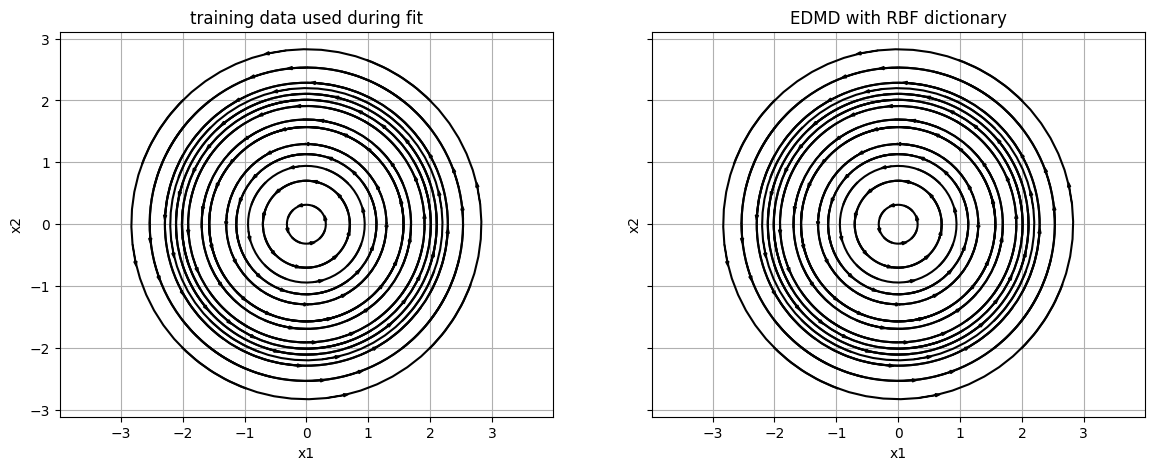

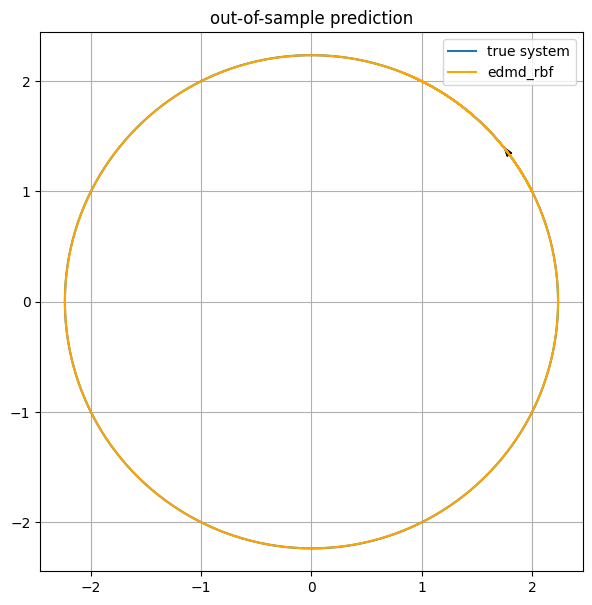

In [13]:
f, ax = plt.subplots(1, 2, sharey=True, figsize=(14, 5))
for _id, df in tsc_data.itertimeseries():
    ax[0].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax[0], df)

ax[0].set_title("training data used during fit")
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
ax[0].axis("equal")
ax[0].grid()

for _id, df in edmd_rbf_values.itertimeseries():
    ax[1].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax[1], df)

ax[1].set_title("EDMD with RBF dictionary")
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
ax[1].axis("equal")
ax[1].grid()


# make out-of-sample prediction
initial_condition = np.array([[2, 1]])
t_eval = np.linspace(0, 7, 400)

ground_truth = solve_limit_cycle(initial_condition, t_eval)
predicted = edmd_rbf.predict(initial_condition, t_eval)

f, ax = plt.subplots(figsize=(7, 7))

ax.plot(ground_truth.loc[:, "x1"], ground_truth.loc[:, "x2"], label="true system")
include_arrow(ax, ground_truth)
ax.plot(predicted.loc[:, "x1"], predicted.loc[:, "x2"], c="orange", label="edmd_rbf")

ax.set_title("out-of-sample prediction")
ax.axis("equal")
ax.grid()
ax.legend()

(100,) (100, 100)


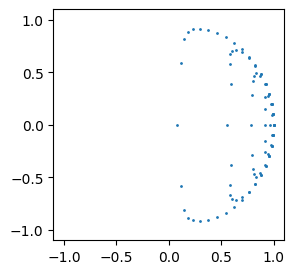

In [14]:
# Now we extract the Koopman matrix of the DMD from before and see if
# eigenvectors and their powers are also close to eigenvectors again.
dictionary_eval = edmd_rbf.dict_steps[0][1].transform(tsc_data)
koopman_matrix = edmd_rbf.dmd_model._compute_koopman_matrix(dictionary_eval)
koopman_eigvals, koopman_eigvecs = np.linalg.eig(koopman_matrix)

print(koopman_eigvals.shape, koopman_eigvecs.shape)

xlim = [-1.1, 1.1]
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(koopman_eigvals.real, koopman_eigvals.imag, s=1)
ax.set_xlim(xlim)
ax.set_ylim(xlim)
ax.set_aspect(1)

is eigenvector? True
#nonzero: 64


(-1.0, 3.0)

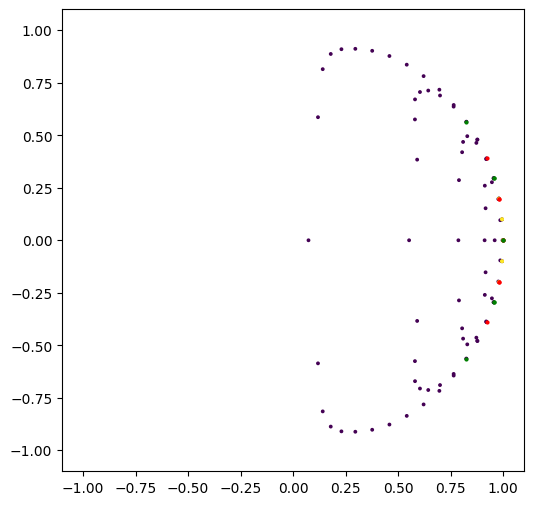

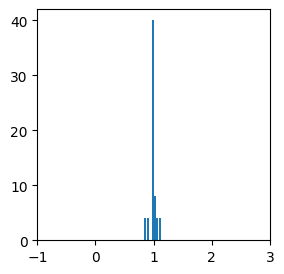

In [34]:
def check_is_eigenvector(matrix, vector, epsilon=1e-1, verbose=False):
    """
    Check if a given vector is an eigenvector of the given matrix - at least, approximatly.
    """
    vector = vector / np.linalg.norm(vector, keepdims=True)
    v1 = matrix @ vector
    idx_nonzer = np.abs(vector) > 1e-2
    approx_eigenvalue = v1[idx_nonzer] / vector[idx_nonzer]
    if verbose:
        print("#nonzero:", np.sum(idx_nonzer))
    return np.std(np.abs(approx_eigenvalue)) < epsilon, approx_eigenvalue

print("is eigenvector?", check_is_eigenvector(koopman_matrix, koopman_eigvecs[:, 0])[0]) # should be ok
is_eigenvector = []
for k in range(koopman_eigvecs.shape[1]):
    is_eigenvector.append(check_is_eigenvector(koopman_matrix, koopman_eigvecs[:,k]**2)[0])

fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.scatter(koopman_eigvals.real, koopman_eigvals.imag, s=3, c=is_eigenvector)
ax.set_xlim(xlim)
ax.set_ylim(xlim)
ax.set_aspect(1)

ax.scatter((koopman_eigvals[is_eigenvector]**2).real, (koopman_eigvals[is_eigenvector]**2).imag, s=4, c='red')
ax.scatter((koopman_eigvals[is_eigenvector]**3).real, (koopman_eigvals[is_eigenvector]**3).imag, s=4, c='green')
ax.set_xlim(xlim)
ax.set_ylim(xlim)
ax.set_aspect(1)


fig, ax = plt.subplots(1, 1, figsize=(3,3))
_, evals = check_is_eigenvector(koopman_matrix, koopman_eigvecs[:, is_eigenvector][:,0]**2, verbose=True)
ax.hist(np.abs(evals));
ax.set_xlim([-1, 3])
